In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# From online

mnist_dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/bbalazs88/Sample_Files/master/mnist_train_small.csv",
    sep=",",
    header=None)

In [3]:
# Use just the first 12,000 records for training/validation.

mnist_dataframe = mnist_dataframe.head(12000)

In [4]:
# First 10.000 rows for train/test, next 2000 for evaluate

labels = mnist_dataframe.loc[0:9999, 0]
features = mnist_dataframe.loc[0:9999, 1:784]

labels_evaluate = mnist_dataframe.loc[10000:11999, 0]
features_evaluate = mnist_dataframe.loc[10000:11999, 1:784]

print(labels.count(), '- labels \n', labels_evaluate.count(), '- labels to evaluate \n',
     features.shape[0], '- features \n', features_evaluate.shape[0], '- features to evaluate')

10000 - labels 
 2000 - labels to evaluate 
 10000 - features 
 2000 - features to evaluate


In [5]:
# Look into the labels

labels[0:10]

0    6
1    5
2    7
3    9
4    5
5    2
6    0
7    6
8    5
9    5
Name: 0, dtype: int64

In [6]:
# Look into the features

features[0:5]

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Because we need 10 categories for the ten possible outcomes, one-hot-encoding needed.

encoded = to_categorical(labels)
encoded_evaluate = to_categorical(labels_evaluate)

print(labels[0])
print(encoded[0], '\n')
print("One-hot-encoding visualize.")

6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 

One-hot-encoding visualize.


### HPO:

#### Dense layers: First I tried two layers with 50-50 neurons. The best accuracy was around 70%. With 512 neurons in each layer, it was worse. With 50-50-60 neuron layers - so I added another layer - the best score was achieved, arounc 90%.

#### Batch_size: The default is 32. I changed to 1, which is really slow, and not accurate. We could go bigger than the default, but not too big, my choice was 150.

#### Optimizer: SGD - works well with shallow networks, and accuracy is the same az Adam's

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 70)                54950     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                3550      
_________________________________________________________________
dense_11 (Dense)             (None, 60)                3060      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                610       
Total params: 62,170
Trainable params: 62,170
Non-trainable params: 0
_________________________________________________________________
Train on 7000 samples, validate on 3000 samples
Epoch 1/30
7000/7000 [==============================] - 2s 265us/step - loss: 9.1756 - acc: 0.4000 - val_loss: 7.7126 - val_acc: 0.5040
Epoch 2/30
7000/7000 [==============================] - 1s 74us/step - loss: 7.3810 - 

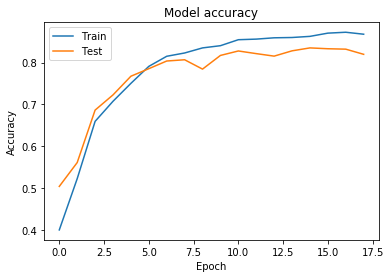

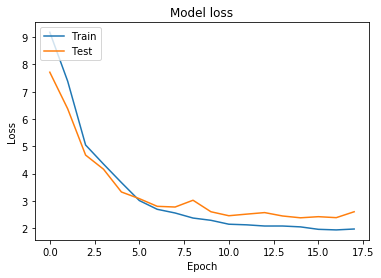

In [16]:
early_stopping_monitor = EarlyStopping(patience=3)

# PyCharm -> model.Sequential()
model = Sequential()
model.add(Dense(70, activation='relu', input_shape=(784, )))
model.add(Dense(50, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

# Compile the model, but first, choose an optimizer
optimizer = keras.optimizers.Adam(lr=0.001)
# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.0001, nesterov=True)

# Tensorboard callback
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='c://DatasRev//TensorBoard//Image_Classifier//', 
                                histogram_freq=0, batch_size=32, write_graph=True, 
                                write_grads=False, write_images=False, embeddings_freq=0, 
                                embeddings_layer_names=None, embeddings_metadata=None, 
                                embeddings_data=None, update_freq='epoch')

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(features, encoded, epochs=30, batch_size=150, validation_split=0.3, 
                    callbacks=[early_stopping_monitor, tb_callback])

# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(features_evaluate, encoded_evaluate)
print('\nTest Accuracy:', test_acc)

2000/2000 [==============================] - 0s 80us/step

Test Accuracy: 0.658



The prediction is: 0
And the answer is: 6


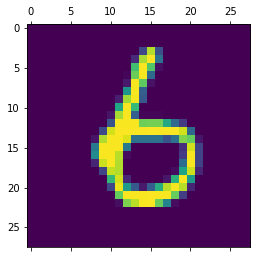

In [10]:
# Random számot generálunk az evaluate adat 2000 sorából, így könnyebb léptetni.
# TODO: csinálni egy loopot, ami predictel 50 számot, és az eredményeket, és a képeket is kinyomtatja.

rand = np.random.randint(0, 2000)
rand

prediction = model.predict([[features_evaluate.iloc[rand]]])
print('\nThe prediction is:', prediction.argmax())
print("And the answer is:", labels_evaluate.iloc[rand])

# Itt nem kellett belekeverni a (-1, 28, 28, 1)-et, mert csak két paramétert vár a matshow.
plt.matshow(features_evaluate.iloc[rand].values.reshape(28,28))
plt.show()

## Misc:

In [11]:
# An example how the raw data looks like.

features_evaluate.iloc[0:2, 590:610]

,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
10000,0,0,0,0,0,0,0,9,124,180,254,242,129,17,0,0,0,0,0,0
10001,0,0,0,0,0,16,169,212,254,254,254,254,251,126,48,0,0,0,0,0


In [12]:
# For prediction it needs a list, not a Series like model.predict(features_evaluate.iloc[45]).
# The difference has printed out.

print(type(features_evaluate.iloc[45]))
print(type([[features_evaluate.iloc[45]]]))

<class 'pandas.core.series.Series'>
<class 'list'>


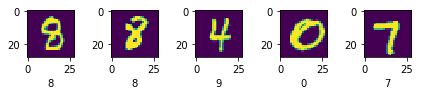

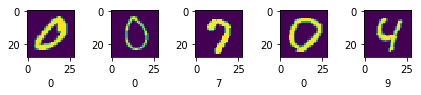

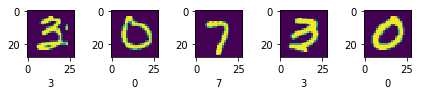

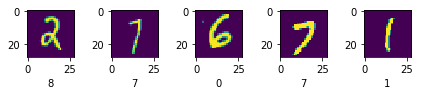

In [13]:
# Visalize the prediction. Not the nicest solution, but it works.

for i in range(0, 4):
    prediction = model.predict([[features_evaluate.iloc[rand]]])  

    f, axarr = plt.subplots(1, 5)
    f.tight_layout()
        
    rand = np.random.randint(0, 2000)
    prediction = model.predict([[features_evaluate.iloc[rand]]])
    axarr[0].set(xlabel=prediction.argmax())
    axarr[0].imshow(features_evaluate.iloc[rand].values.reshape(28,28))
    
    rand = np.random.randint(0, 2000)
    prediction = model.predict([[features_evaluate.iloc[rand]]])
    axarr[1].set(xlabel=prediction.argmax())
    axarr[1].imshow(features_evaluate.iloc[rand].values.reshape(28,28))
    
    rand = np.random.randint(0, 2000)
    prediction = model.predict([[features_evaluate.iloc[rand]]])
    axarr[2].set(xlabel=prediction.argmax())
    axarr[2].imshow(features_evaluate.iloc[rand].values.reshape(28,28))
    
    rand = np.random.randint(0, 2000)
    prediction = model.predict([[features_evaluate.iloc[rand]]])
    axarr[3].set(xlabel=prediction.argmax())
    axarr[3].imshow(features_evaluate.iloc[rand].values.reshape(28,28))
   
    rand = np.random.randint(0, 2000)
    prediction = model.predict([[features_evaluate.iloc[rand]]])
    axarr[4].set(xlabel=prediction.argmax())
    axarr[4].imshow(features_evaluate.iloc[rand].values.reshape(28,28))

    plt.show()

In [14]:
# TensorBoard load, and show

%load_ext tensorboard.notebook
%tensorboard --logdir 'c://DatasRev//TensorBoard//Image_Classifier//'

Reusing TensorBoard on port 6006 (pid 15720), started 3:17:21 ago. (Use '!kill 15720' to kill it.)